In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score

random.seed(42)

In [3]:
df = pd.read_csv('train.csv', index_col='id')

df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower() #Переименовываем колонки для более удобной работы

In [5]:
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 

df_num = df.select_dtypes(include=np.number)
df_num.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount,year,month
count,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03,2.021621e+03,6.492671e+00
std,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02,1.476008e+00,3.432689e+00
min,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01,2.019000e+03,1.000000e+00
10%,2.200000e+01,2.627000e+03,0.000000e+00,9.936849e+00,0.000000,2.000000e+00,3.830000e+02,1.000000e+00,1.500000e+02,2.020000e+03,2.000000e+00
25%,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02,2.020000e+03,4.000000e+00
50%,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02,2.022000e+03,6.000000e+00
75%,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03,2.023000e+03,9.000000e+00
90%,6.000000e+01,8.107500e+04,4.000000e+00,4.328134e+01,2.000000,1.800000e+01,7.920000e+02,9.000000e+00,2.363000e+03,2.024000e+03,1.100000e+01
max,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03,2.024000e+03,1.200000e+01


In [6]:
print('Пропуски: ', df_num.isna().sum())

#Пропуски заменим на средние значение позже в модели pipeline

Пропуски:  age                      18705
annual_income            44949
number_of_dependents    109672
health_score             74076
previous_claims         364029
vehicle_age                  6
credit_score            137882
insurance_duration           1
premium_amount               0
year                         0
month                        0
dtype: int64


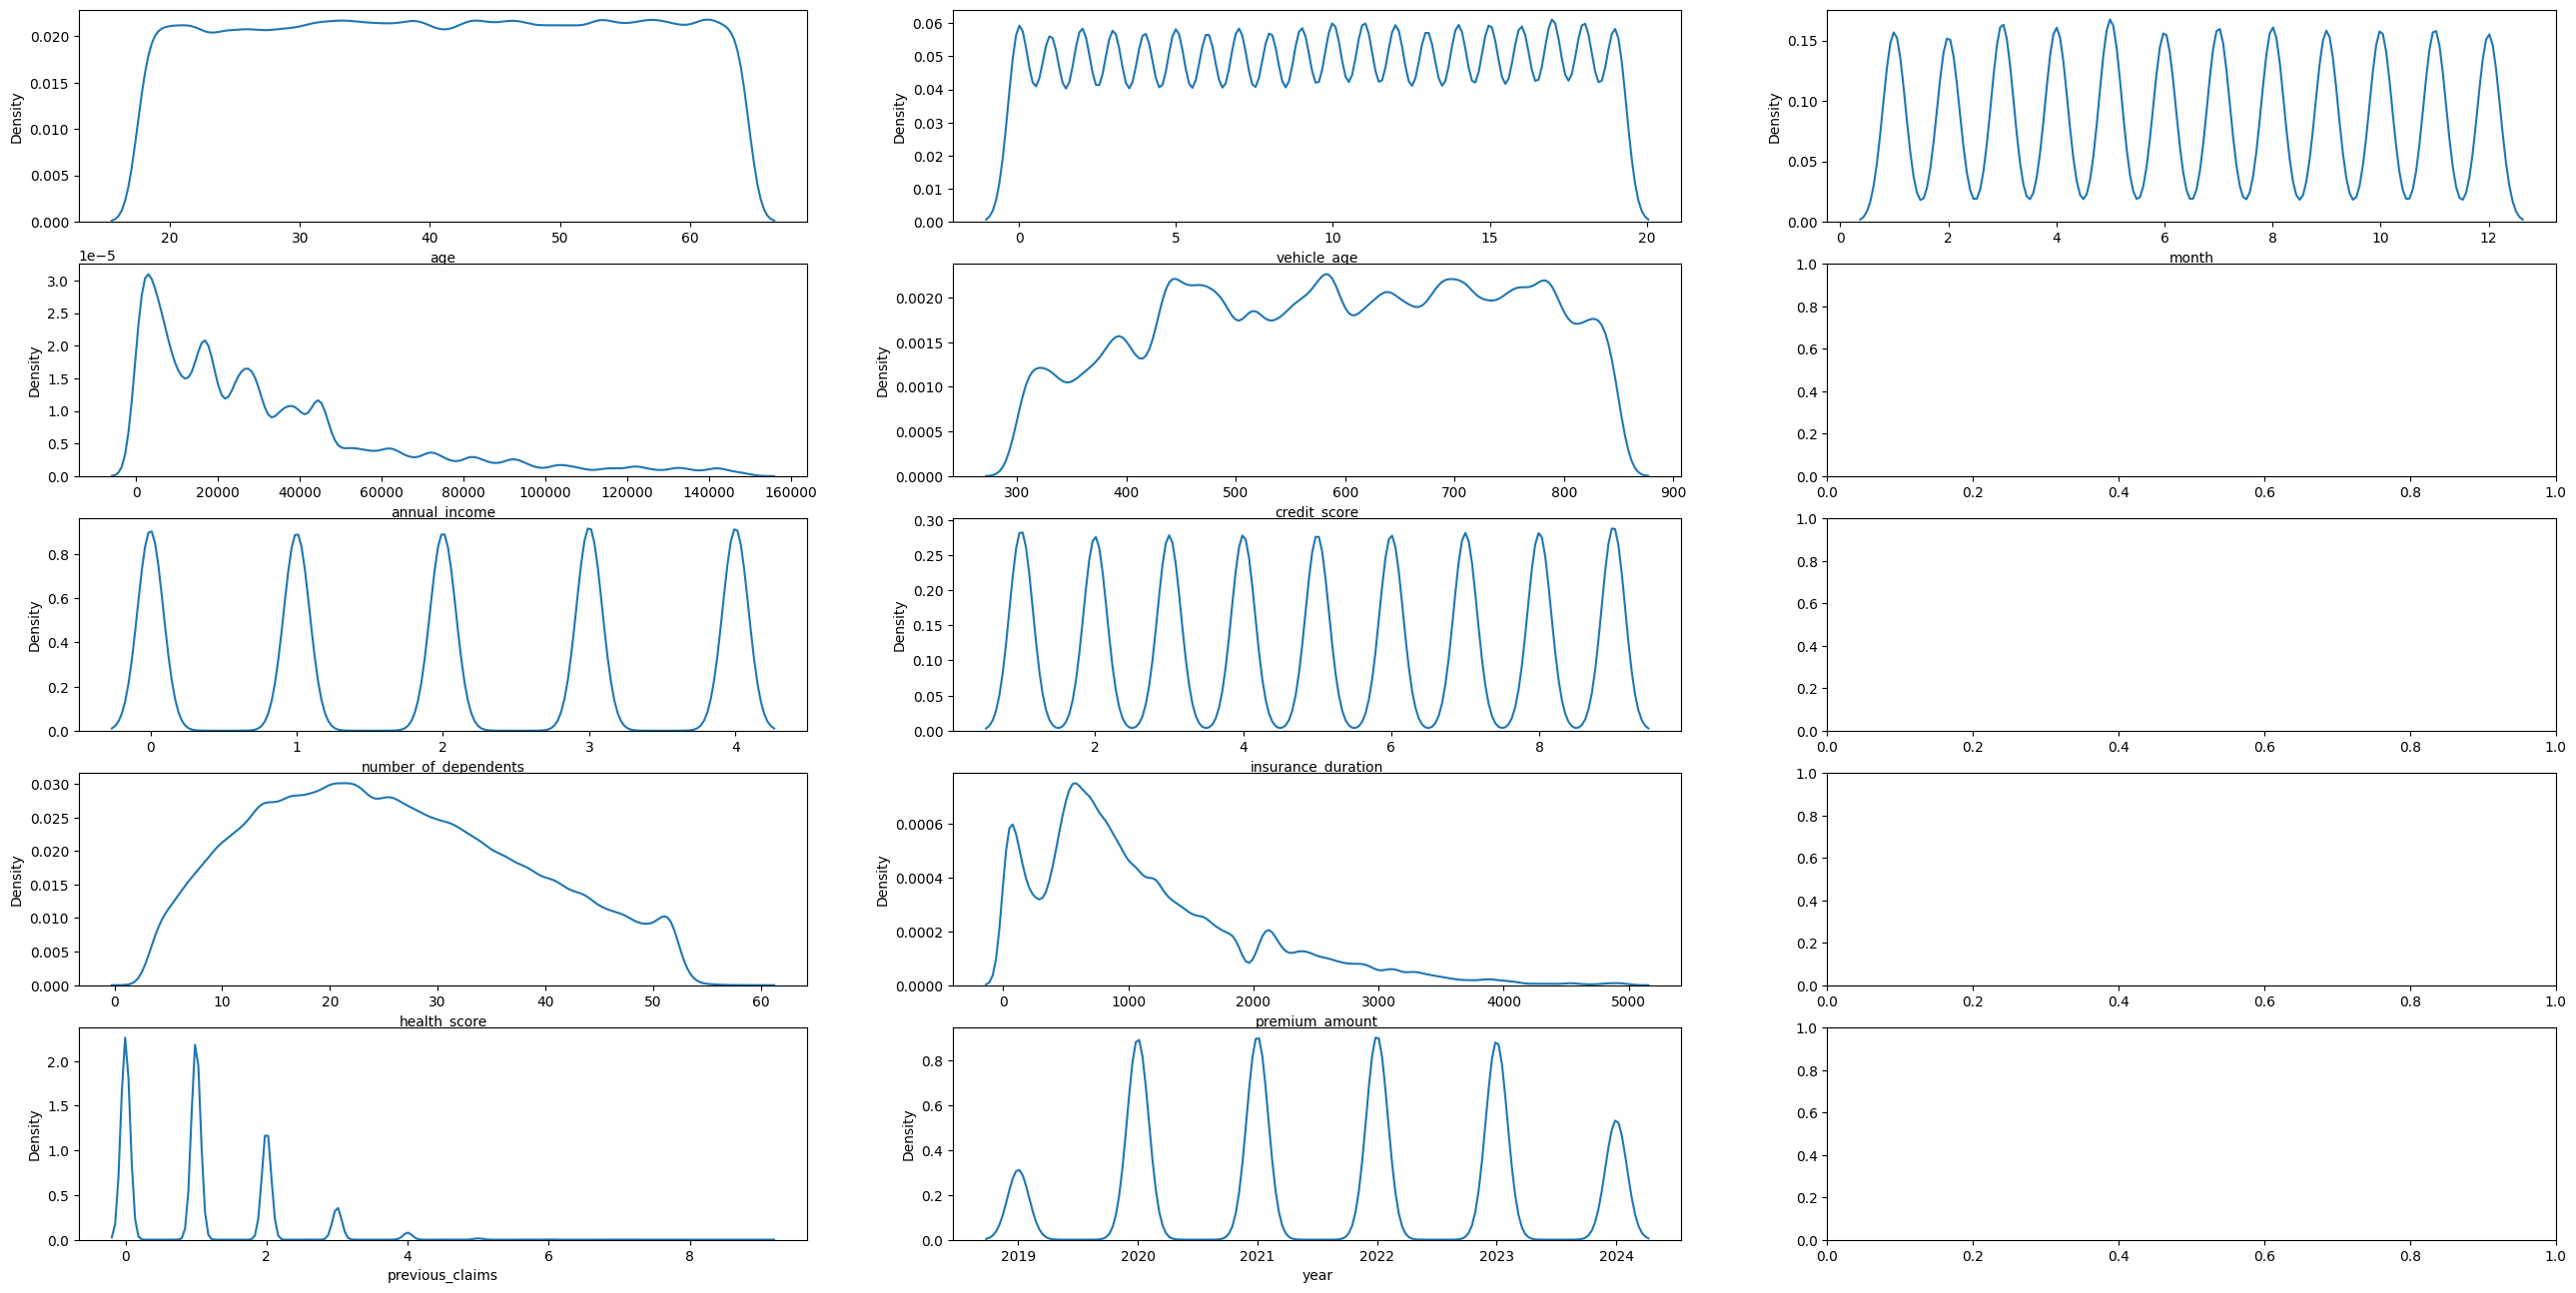

In [7]:
df_num = df.select_dtypes(include=np.number)

features = list(df_num.columns)
fig, axes = plt.subplots(5, len(features) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(features):
    sns.kdeplot(data=df_num, x=col, ax=axes[idx % 5, idx // 5])

In [8]:
df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению


<Axes: >

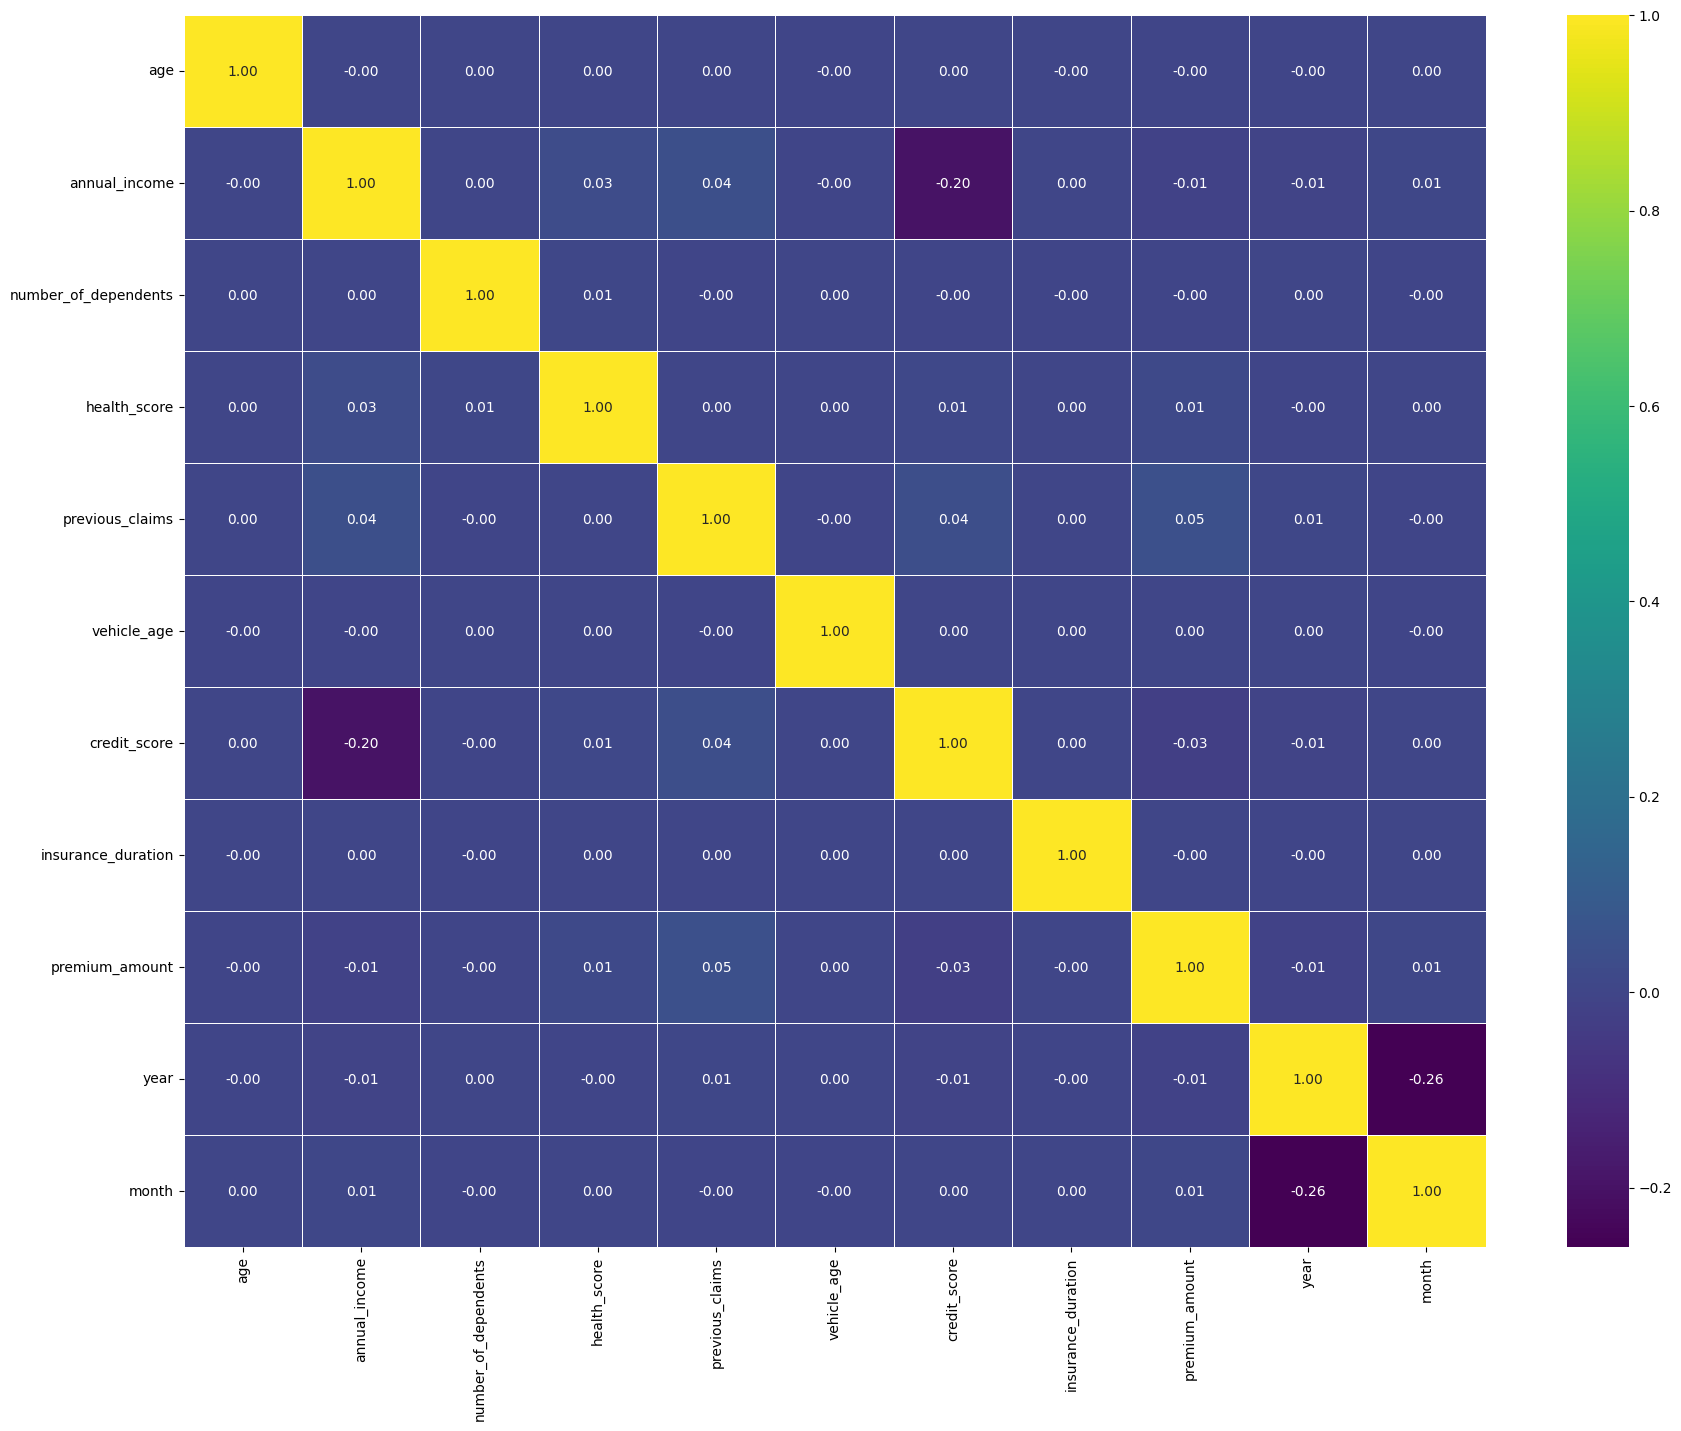

In [9]:
#Корреляция признаков между собой
plt.figure(figsize=(21, 16))
correlation_matrix = df_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)

In [10]:
#Преобразуем в категориальные фичи
categorial = df.select_dtypes(include=np.object_).columns.to_list()

for col in categorial:
    df[col] = pd.Categorical(df[col])

df[categorial].isna().sum()

gender                     0
marital_status         18529
education_level            0
occupation            358075
location                   0
policy_type                0
customer_feedback      77824
smoking_status             0
exercise_frequency         0
property_type              0
dtype: int64

In [11]:
#Посмотрим какие категори бывают
categorical = df.select_dtypes(include=['category']).columns.tolist()

cat_unique = {var: df[var].dropna().unique().tolist() for var in categorical}
cat_unique


{'gender': ['Female', 'Male'],
 'marital_status': ['Married', 'Divorced', 'Single'],
 'education_level': ["Bachelor's", "Master's", 'High School', 'PhD'],
 'occupation': ['Self-Employed', 'Employed', 'Unemployed'],
 'location': ['Urban', 'Rural', 'Suburban'],
 'policy_type': ['Premium', 'Comprehensive', 'Basic'],
 'customer_feedback': ['Poor', 'Average', 'Good'],
 'smoking_status': ['No', 'Yes'],
 'exercise_frequency': ['Weekly', 'Monthly', 'Daily', 'Rarely'],
 'property_type': ['House', 'Apartment', 'Condo']}

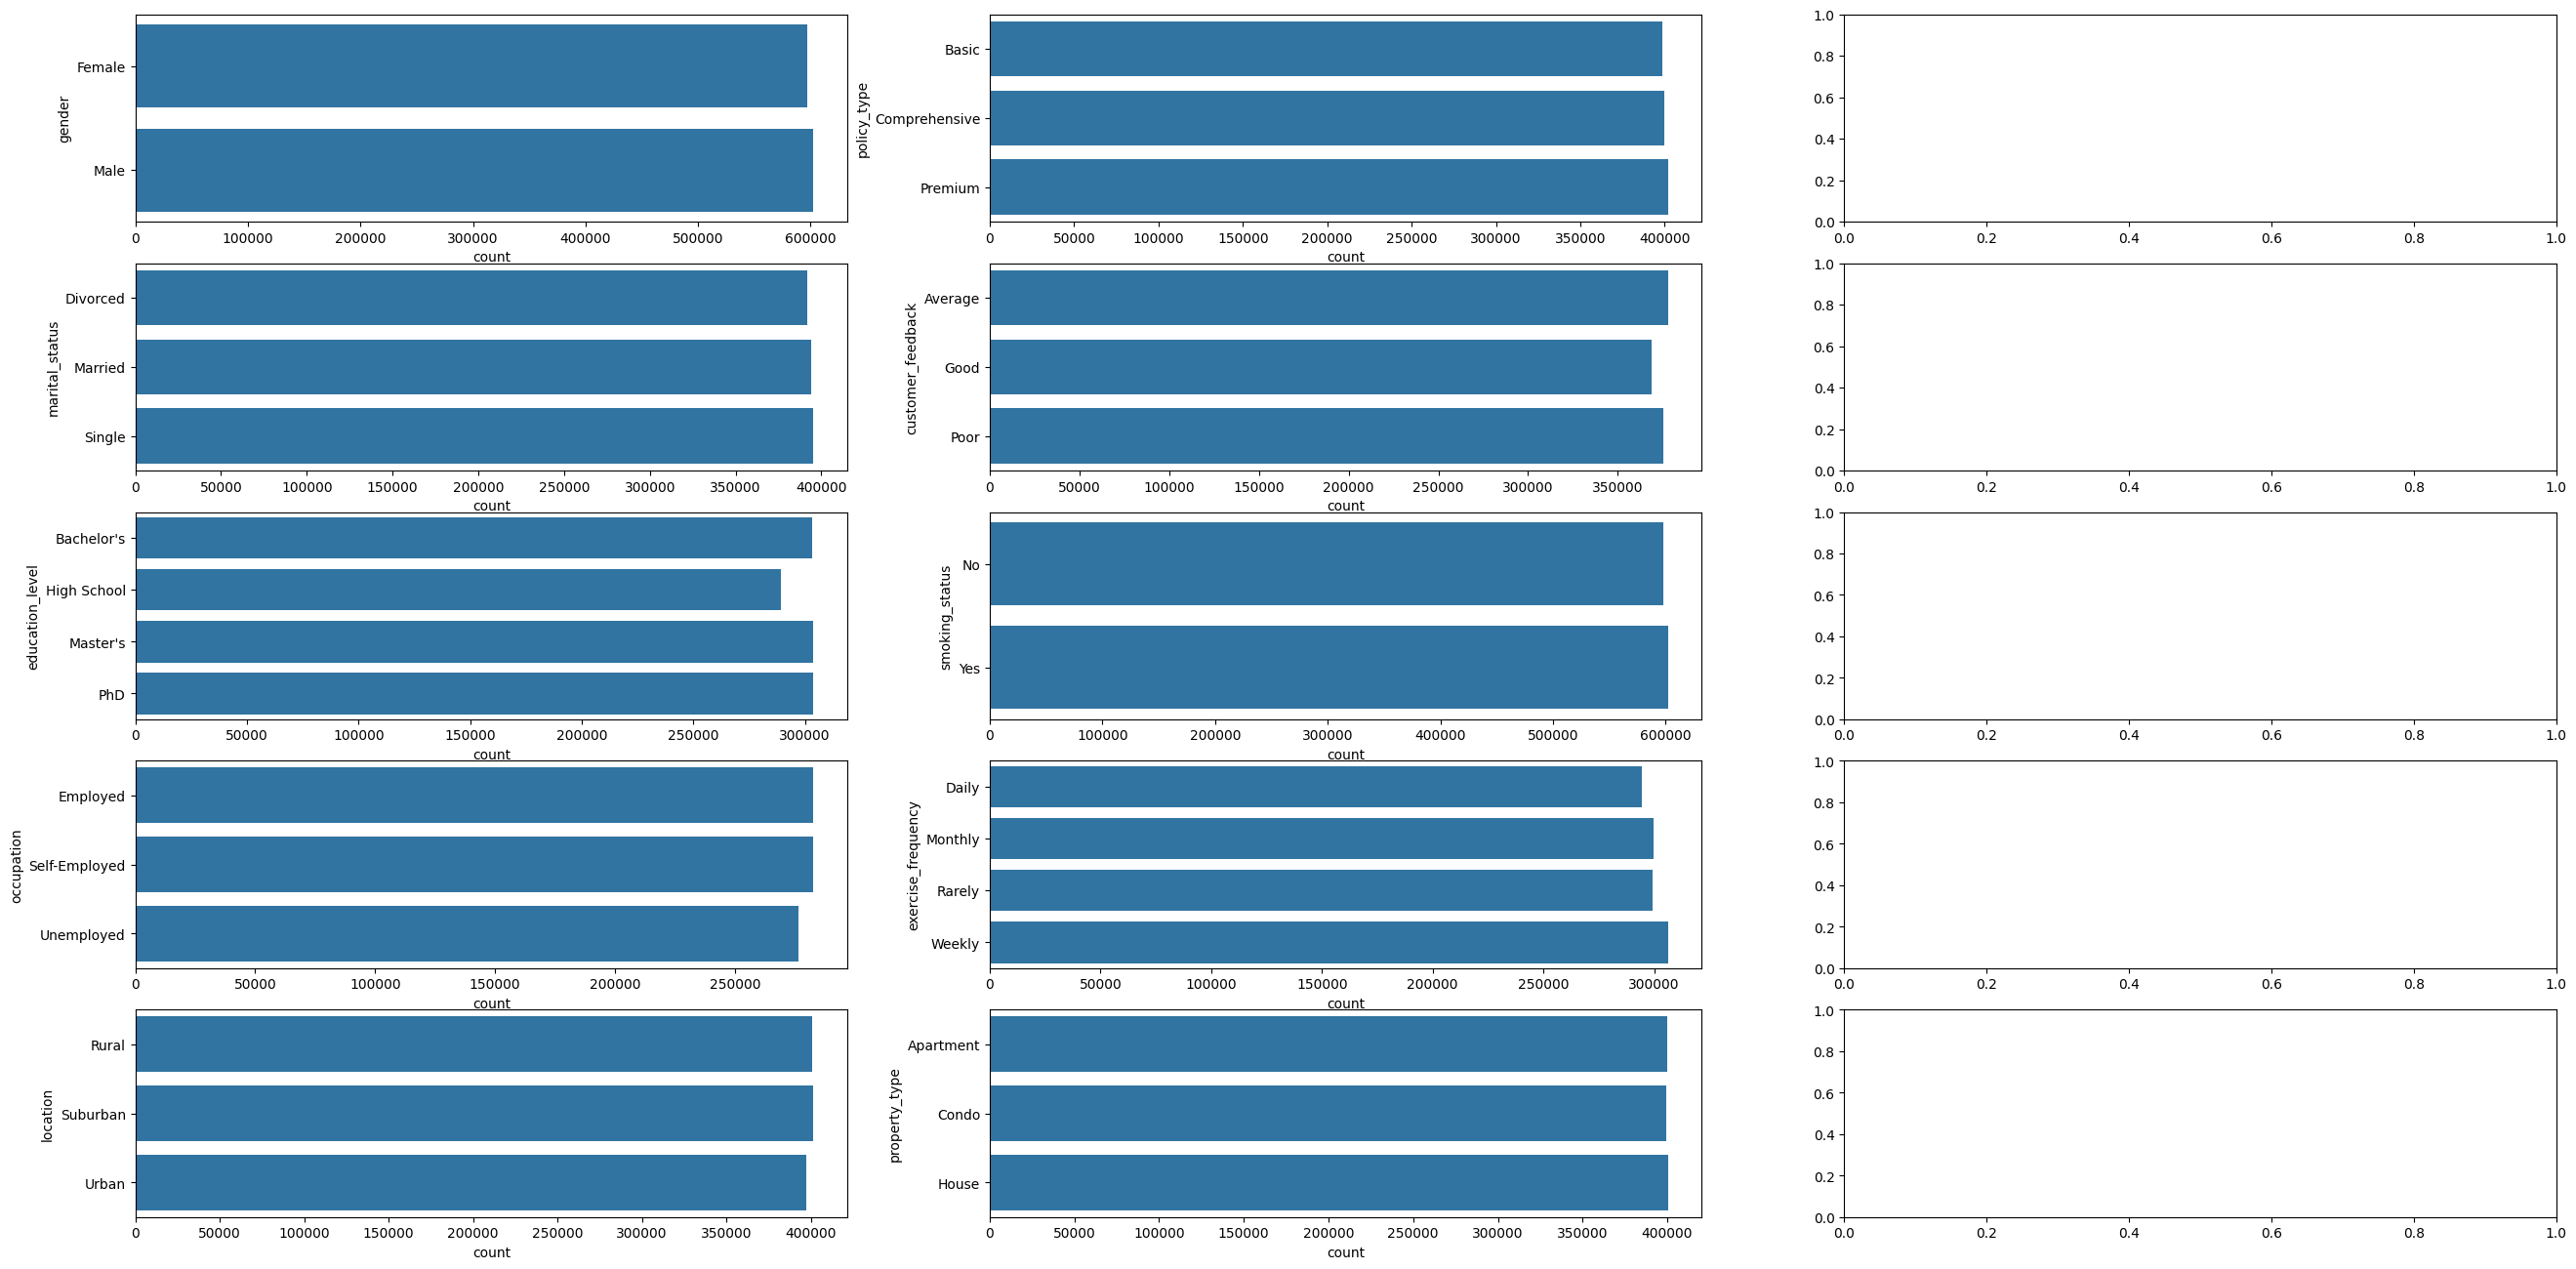

In [12]:
#Построим распределение категориальных признаков
fig, axes = plt.subplots(5, len(categorial) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(categorial):
    sns.countplot(data=df[col].dropna(), ax=axes[idx % 5, idx // 5])

In [13]:
#заменим пропуски на среднее знаечние  для создания новых признаков
df['previous_claims'].fillna('mean')

#Создаем новые фичи

df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
df['policy_ratio'] = df['insurance_duration'] / df['age']
df['credit_health'] = df['credit_score'] * df['health_score']
df['credit_health_interaction'] = df['credit_score'] * df['health_score']
df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
df['dependents_income'] = (df['number_of_dependents'] / df['annual_income']) * 10000

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)


# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])


In [15]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']


In [16]:
#Создаем модели

numeric_transforms = [
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
]

num_transformer = Pipeline(steps=numeric_transforms)

best_features = 20

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

lasso_m = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', Ridge())
])

ridge_m = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', Lasso())
])

elastic_m = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', ElasticNet())
])

In [17]:

target_col = 'premium_amount'
y = df[target_col]
df_train = df[numerical_features + onehot_features + education_features + policy_feature + feedback_feature + exercise_feature + location_feature]
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2)

In [18]:
lasso_m.fit(X_train, y_train)
ridge_m.fit(X_train, y_train)
elastic_m.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', ElasticNet())])

In [19]:
y_pred_lasso_test = lasso_m.predict(X_test)
y_pred_ridge_test = ridge_m.predict(X_test)
y_pred_elastic_test = elastic_m.predict(X_test)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()


print_score('Lasso регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, y_pred_lasso_test)
print_score('Ridge регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
                                         , r2_score], y_test, y_pred_ridge_test)
print_score('Elastic регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
                                         , r2_score], y_test, y_pred_elastic_test)


Score for Lasso регрессия
mean_absolute_error: 664.9601
mean_squared_error: 740699.1000
mean_absolute_percentage_error: 3.0091
r2_score: 0.0053

Score for Ridge регрессия
mean_absolute_error: 665.0507
mean_squared_error: 740723.5709
mean_absolute_percentage_error: 3.0092
r2_score: 0.0052

Score for Elastic регрессия
mean_absolute_error: 666.3407
mean_squared_error: 742789.8713
mean_absolute_percentage_error: 3.0100
r2_score: 0.0024



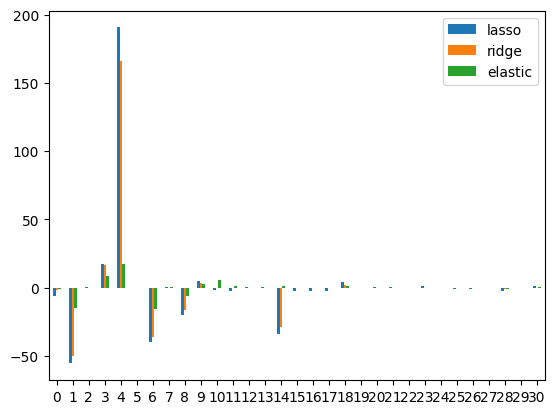

In [37]:

coef_df = pd.DataFrame()
coef_df['lasso'] = lasso_m.named_steps['regression'].coef_
coef_df['ridge'] = ridge_m.named_steps['regression'].coef_
coef_df['elastic'] = elastic_m.named_steps['regression'].coef_


ax = coef_df.plot(y=["lasso", "ridge", "elastic"], kind="bar", rot=0)


In [33]:
#подбираем оптимальные параметры для Lasso при помощи hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

space = {
    'alpha': hp.loguniform('alpha', np.log(0.01), np.log(10))  # Логарифмическое распределение для alpha для более оптимального поиска
}

def objective(params):
    alpha = params.get('alpha')

    model = Pipeline(steps=[
        ('preprocessor', feature_preprocessor),
        ('regression', Lasso(alpha))
    ])

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores) #Усредняем оценку mse по разбивкам
    return {'loss': -mean_score, 'status': STATUS_OK}      #hyperopt ищет минимальное значение поэтому -mean_score

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

print(f'best params: {best}')
best_alpha = best.get('alpha')


100%|██████████| 20/20 [12:32<00:00, 37.64s/trial, best loss: 745223.3660339387]
best params: {'alpha': np.float64(0.3739462529043735)}


In [34]:
final_model = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', Lasso(best_alpha))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', Lasso(alpha=np.float64(0.3739462529043735)))])

In [35]:
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)


print_score('Оптимизированная Lasso train', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_train, y_pred_train)
print_score('Оптимизированная Lasso test', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, y_pred_test)



Score for Оптимизированная Lasso train
mean_absolute_error: 667.0505
mean_squared_error: 745180.7828
mean_absolute_percentage_error: 3.0266
r2_score: 0.0053

Score for Оптимизированная Lasso test
mean_absolute_error: 664.9905
mean_squared_error: 740697.5124
mean_absolute_percentage_error: 3.0091
r2_score: 0.0053



([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'num__previous_claims'),
  Text(1, 0, 'num__annual_income'),
  Text(2, 0, 'num__credit_score'),
  Text(3, 0, 'num__claims_to_income_ratio'),
  Text(4, 0, 'num__year'),
  Text(5, 0, 'num__health_score'),
  Text(6, 0, 'onehot__marital_status_Single'),
  Text(7, 0, 'num__month'),
  Text(8, 0, 'num__age'),
  Text(9, 0, 'feedback__customer_feedback'),
  Text(10, 0, 'education__education_level'),
  Text(11, 0, 'location__location'),
  Text(12, 0, 'num__number_of_dependents'),
  Text(13, 0, 'num__claim_frequency'),
  Text(14, 0, 'num__dependents_income'),
  Text(15, 0, 'num__credit_health_interaction'),
  Text(16, 0, 'num__credit_health'),
  Text(17, 0, 'num__policy_ratio'),
  Text(18, 0, 'num__insurance_duration'),
  Text(19, 0, 'num__vehicle_age'),
  Text(20, 0, 'onehot__gender_Female'),
  Text(21, 0, 'o

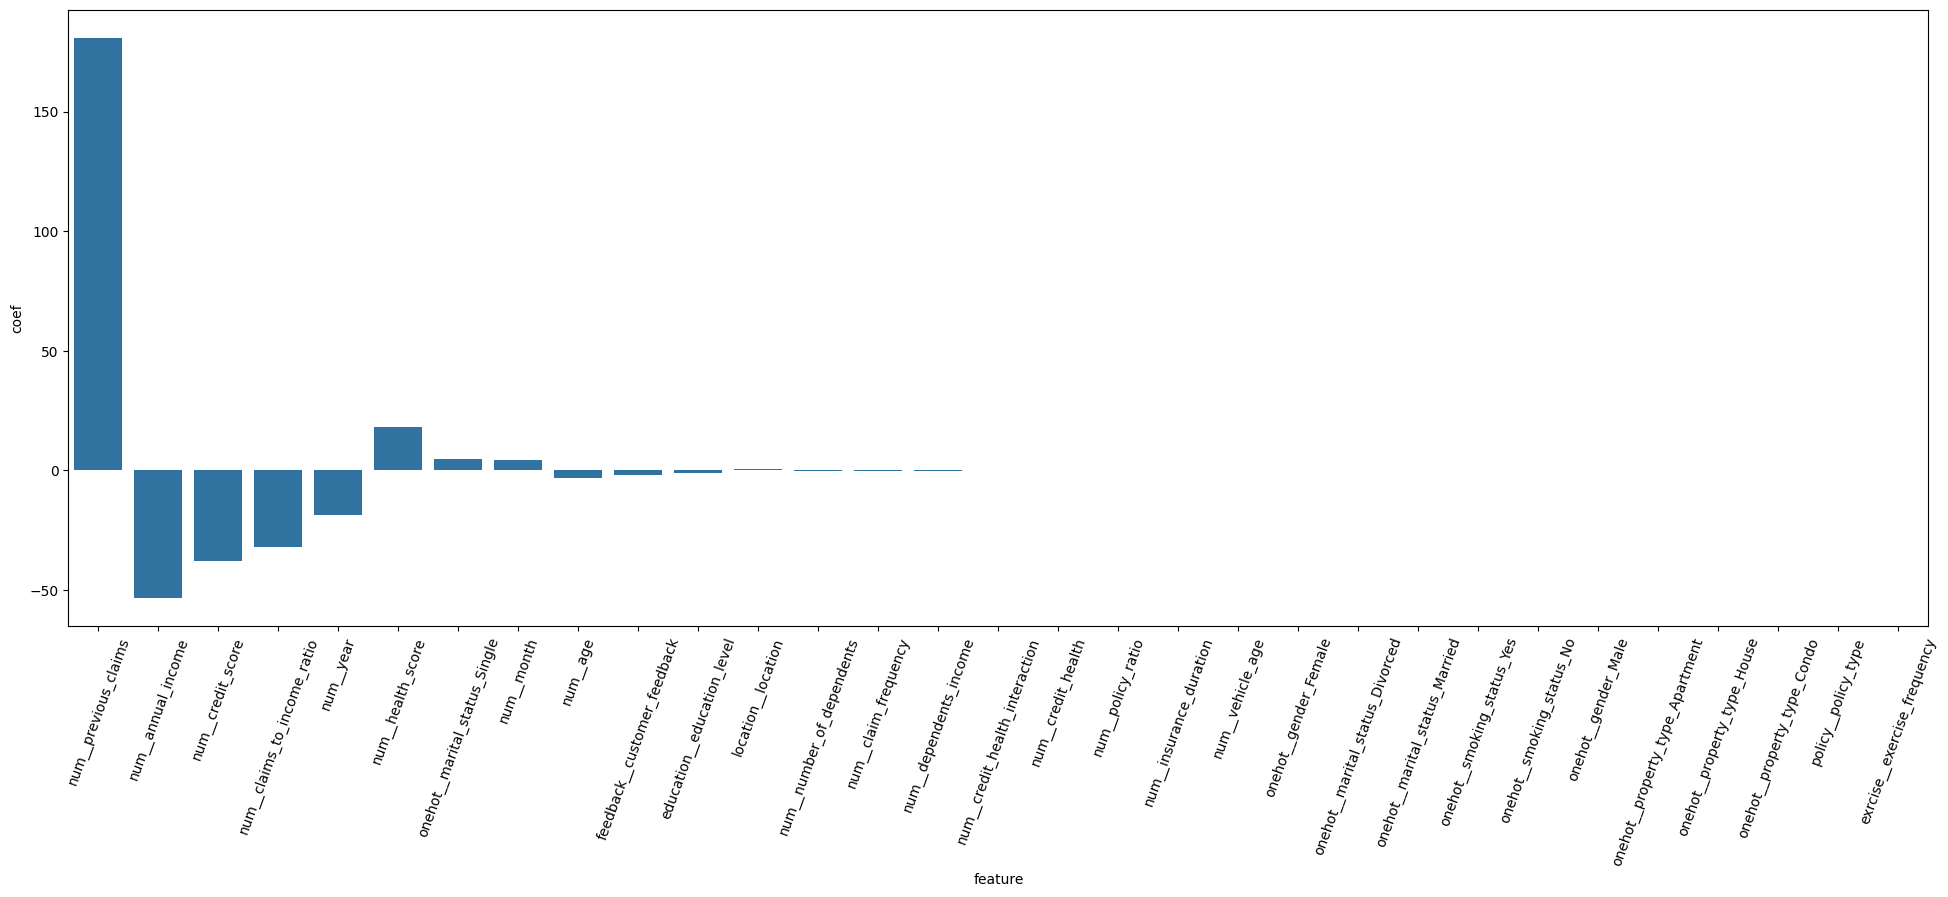

In [36]:
coef_df = pd.DataFrame({
    'feature': final_model.named_steps['preprocessor'].get_feature_names_out(),
    'coef': final_model.named_steps['regression'].coef_
})

plt.figure(figsize=(24, 8))
sns.barplot(data = coef_df.sort_values(by=['coef'], ascending=False, key = lambda x: np.abs(x)),    #сортируем по убыванию коэффициентов, 
            x='feature',
            y='coef')
plt.xticks(rotation=70)

Построены 3 линейный модели с регуляризацией (LASSO, RIDGE, Elastic). Посчитаны метрики качества на тестовых данных.
Для модели LASSO Проведена оптимизация гиперпараметров при помощи hyperopt. Ошибка MSE на тестовых данных снизилась с 740699.1000 до 740697.5124